# Задание 1
Собрать дашборд с ключевыми метриками (от 4 до 6) для СЕО, на основании которых он будет судить о "здоровье" бизнеса, эффективности текущих операций и т.д. **каждый день**.


Для оценки какого-то параметра **каждый день** многие метрики могут быть неэффективны, так как колебания значений могут быть достаточно серьезными, чтобы не почувствовать изменения глобального тренда.
Единственная метрика, которую я бы рассматривал изо дня в день без преобразований, из тех, которые доступны - оценка приложения.
Широкая градация (по 0,1 балла), при большом количестве клиентов позволяет отслеживать медленное изменение в настроении клиента. Метрика останется стабильной изо дня в день, если только не будет целенаправленной атаки на неё.

Для предоставления информации каждый день, больше походят функции, используемые в техническом анализе инвестиций, такие как скользящее среднее (moving average). Это функция, значение которой равно среднему за выбранный период (например 7-day moving average или 50-day moving average). Такая функция позволяет сгладить краткосрочные колебания и отслеживать тенденции, вместо того, чтобы фокусироваться на единовременном значении.

В качестве метрик, сравниваемых с этой функцией, можно использовать средний чек, количество заказов, общую прибыль, как умножение среднего чека на количество заказов, среднее время доставки и, например, долю заказов с заменой.

# Задание 2

Твое задание: найти все интересные на твой взгляд инсайты и представь их в любом удобном виде (ноутбук желательно приложить). 


Прикладываю ниже код, который использовал при анализе. Визуализация данных в самом конце.

In [1]:
import psycopg2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Загружаю всю информацию в отдельные датафреймы
conn = psycopg2.connect(dbname='hr-analytics', user='analytics', 
                        password='HRanalytics', host='rc1c-fhrb9f1e0l9g611h.mdb.yandexcloud.net',
                        sslmode = 'require', port = 6432)
df_orders = pd.read_sql("select * from orders",conn)
df_delivery_windows = pd.read_sql("select * from delivery_windows",conn)
df_stores = pd.read_sql("select * from stores",conn)
df_addresses = pd.read_sql("select * from addresses",conn)
df_replacements = pd.read_sql("select * from replacements",conn)
df_cancellations = pd.read_sql("select * from cancellations",conn)

In [2]:
# Проверяю, есть ли пробелы
df_list=[df_orders,df_delivery_windows,df_stores,df_addresses,df_replacements,df_cancellations]

for item in df_list:
    print(item.isnull().sum())
# Пробел один, в целом данные заполнены

id                    0
user_id               0
total_cost            0
cost                  0
item_total            0
promo_total           0
total_weight          0
total_quantity        0
state                 0
shipped_at            0
created_at            0
ship_address_id       0
store_id              0
delivery_window_id    0
dtype: int64
store_id     0
id           0
starts_at    0
ends_at      0
time_zone    0
dtype: int64
id             0
city           0
retailer_id    0
dtype: int64
lat               0
lon               0
id                0
elevator    1149771
floor             0
dtype: int64
order_id    0
item_id     0
state       0
dtype: int64
order_id    0
item_id     0
state       0
dtype: int64


In [3]:
# Смотрю, какие у меня есть колонки в основном датасете и общую информацию о нём. 
print(df_orders.columns)
print(df_orders.describe())
print(df_orders.info())

Index(['id', 'user_id', 'total_cost', 'cost', 'item_total', 'promo_total',
       'total_weight', 'total_quantity', 'state', 'shipped_at', 'created_at',
       'ship_address_id', 'store_id', 'delivery_window_id'],
      dtype='object')
                 id       user_id     total_cost           cost  \
count  7.204330e+05  7.204330e+05  720433.000000  720433.000000   
mean   2.747200e+06  6.385489e+05     171.820556     252.459416   
std    1.446098e+06  5.405112e+05     152.639804     144.192244   
min    7.569140e+05  3.100000e+01    -148.000000       0.000000   
25%    1.496435e+06  1.867060e+05      98.000000     199.000000   
50%    2.423437e+06  3.630850e+05     158.000000     249.000000   
75%    4.129816e+06  1.129740e+06     263.000000     299.000000   
max    5.444849e+06  1.837484e+06   30000.000000   30000.000000   

          item_total    promo_total  total_weight  total_quantity  \
count  720433.000000  720433.000000  7.204330e+05   720433.000000   
mean     4936.180057  

In [4]:
# В общей сумме доставки есть отрицательные значения, 
# выведу для дальнейшего анализа.
df_orders[df_orders['total_cost']<0]
#В информации к датасету сказано, что total_cost = cost + promo_total,
#не сходится, но тут всего 4 значения, оставлю в датасете.

,id,user_id,total_cost,cost,item_total,promo_total,total_weight,total_quantity,state,shipped_at,created_at,ship_address_id,store_id,delivery_window_id
240505,802572,60247,-148.0,299.0,5615,0.0,35357,43,shipped,2018-09-20 14:36:11,2018-09-19 04:12:17,274349,11,247485
381924,795110,4585,-99.0,497.0,3424,0.0,17877,64,shipped,2018-10-10 17:31:12,2018-09-15 12:18:13,940822,21,264264
382148,802465,19214,-99.0,299.0,2139,0.0,35228,31,shipped,2018-09-20 12:11:22,2018-09-18 22:45:05,858935,21,247582


In [5]:
# Собираю датафрейм, который буду анализировать.
# Первая колонка - месяцы, в которые создан заказ. 
# Колонки - месяц и день заказа
df = pd.DataFrame()
df['month'] = df_orders['created_at'].apply(lambda x: 
                                            x.month if x.year ==2018
                                            else x.month+12)
df['day'] = df_orders['created_at'].apply(lambda x: 
                                            x.dayofyear if x.year ==2018
                                            else x.dayofyear+365)
#Пригодится для оформления графиков
categories=['Янв', 'Фев', 'Мар', 'Апр','Май','Июн', 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя','Дек','Янв', 'Фев', 'Мар', 'Апр','Май','Июн', 'Июл', 'Авг']

In [6]:
#Добавлю стоимость всех заказов
df['item_total'] = df_orders['item_total']

#Столбец с часом оформления заказа
df['hour'] = df_orders['created_at'].dt.strftime('%H').astype('int')

# Столбец с стоимостью промокодов
df['promo_total'] = df_orders['promo_total']

# Столбец с длительностью доставки, как разница между временем доставки и
# временем регистрации, в часах
df['packing_time'] = df_orders['shipped_at'] - df_orders['created_at']
df['packing_time'] = df['packing_time'].apply(lambda x: x.total_seconds()/3600)



In [7]:
# Во время анализа потребовалась очистка данных по времени доставки.
print(df['packing_time'].describe())
print('Количество заказов с отрицательным временем доставки: {}'.format(len(df[df['packing_time']<0])))
# 3 заказа статистически не значимы, но максимальное значение очень сильно отличается от 3 квантиля.
# Необходимо избавиться от выбросов.

count    720433.000000
mean        104.338779
std         353.174553
min         -71.959722
25%          12.112500
50%          25.301944
75%          85.998056
max       11502.736389
Name: packing_time, dtype: float64
Количество заказов с отрицательным временем доставки: 3


In [8]:
# Пишу функцию для исключения выбросов
def anomaly_exclude_hist(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_out
df_clean = anomaly_exclude_hist(df)

#Все графики будут ниже

In [9]:
# Пора перейти к другим датафреймам.
# Оценю величину окон для загрузки по регионам
df_delivery_windows['delivery_time'] = df_delivery_windows['ends_at'] - df_delivery_windows['starts_at']
df_delivery_windows['delivery_time'] = df_delivery_windows['delivery_time'].apply(lambda x: x.total_seconds()/3600)
df_delivery_windows.groupby('time_zone')['delivery_time'].mean()
# Похоже, это просто техническая информация, разница между регионами незначительная.

time_zone
Asia/Omsk             2.071230
Asia/Yekaterinburg    2.097960
Europe/Kaliningrad    2.000000
Europe/Moscow         2.154512
Europe/Samara         2.120651
Name: delivery_time, dtype: float64

In [10]:
#Топ 10 самых популярных магазинов
df_orders.groupby('store_id')['id'].count().sort_values(ascending = False)[:10]


store_id
14     57606
2      52511
12     47574
8      45599
1      44557
10     41374
21     40468
11     35134
3      32806
105    25965
Name: id, dtype: int64

In [11]:
#10 самых заменяемых товаров
df_replacements.item_id.value_counts()[:10].sort_values(ascending = False)[:10]

61396047    1
21546061    1
27839564    1
73989194    1
67691593    1
70465081    1
27827270    1
6861891     1
40356425    1
76088362    1
Name: item_id, dtype: int64

In [12]:
#10 самых отменяемых товаров
df_cancellations.item_id.value_counts().sort_values(ascending = False)[:10]

20973569    1
69220359    1
18941985    1
18933789    1
29487166    1
22630775    1
11168309    1
14686211    1
35659780    1
16789510    1
Name: item_id, dtype: int64

In [13]:
#Доля заказов с отменой
print('Доля заказов, в которых есть отмена: {}'.format(round((len(df_cancellations['order_id'].unique())/len(df_orders.id)),2)))
#Доля заказов с заменой
print('Доля заказов, в которых есть замена: {}'.format(round((len(df_replacements['order_id'].unique())/len(df_orders.id)),2)))

Доля заказов, в которых есть отмена: 0.69
Доля заказов, в которых есть замена: 0.62


In [14]:
#Подготовка датафрейма с отмененными заказами
df_canc = df_cancellations.drop(columns = ['state'], axis = 1)
df_orders_canc = df_orders.join(df_canc.set_index('order_id'), on = 'id')
df_orders_canc.dropna(inplace = True)
df_orders_canc['item_id']=df_orders_canc['item_id'].apply(lambda x : int(x))

In [15]:
#Топ 10 магазинов с самым большим количеством отмен в заказах
df_orders_canc.groupby('store_id')['item_id'].count().sort_values(ascending = False)[0:10]

store_id
14    101293
8      92721
2      83923
1      82717
21     75429
12     73287
11     72302
10     71790
3      65733
90     47486
Name: item_id, dtype: int64

In [16]:
#Функция отрисовки ежемесячных графиков.

def df_plot(df,group,what,agg,xlabel,ylabel,title):
    data = df.groupby(group)[what].agg(agg)
    f, ax = plt.subplots(figsize=(20, 6))
    ax = sns.barplot(data.keys(),data,color = '#69ee69')
    ax.set_xticklabels(categories,{'fontsize': 15,
     'fontweight': 50,
     'verticalalignment': 'top',
     'horizontalalignment': 'right'})
    ax.set_yticklabels(ax.get_yticks(),{'fontsize': 15,
     'fontweight': 50,
     'verticalalignment': 'top',
     'horizontalalignment': 'right'})
    ax.tick_params(axis='x', rotation=70)
    ax.grid(axis = 'y')
    ax.axvline(x=11.5, color='red')
    ax.text(len(data.keys())/4, data.max()/2, '2018',size = '20')
    ax.text(3*len(data.keys())/4, data.max()/2, '2019',size = '20')
    ax.set_xlabel(xlabel,size = 20)
    ax.set_ylabel(ylabel,size = 20)
    ax.set_title(title, size = 25)
    return ax

# Ниже идет визуализация отобранных данных.

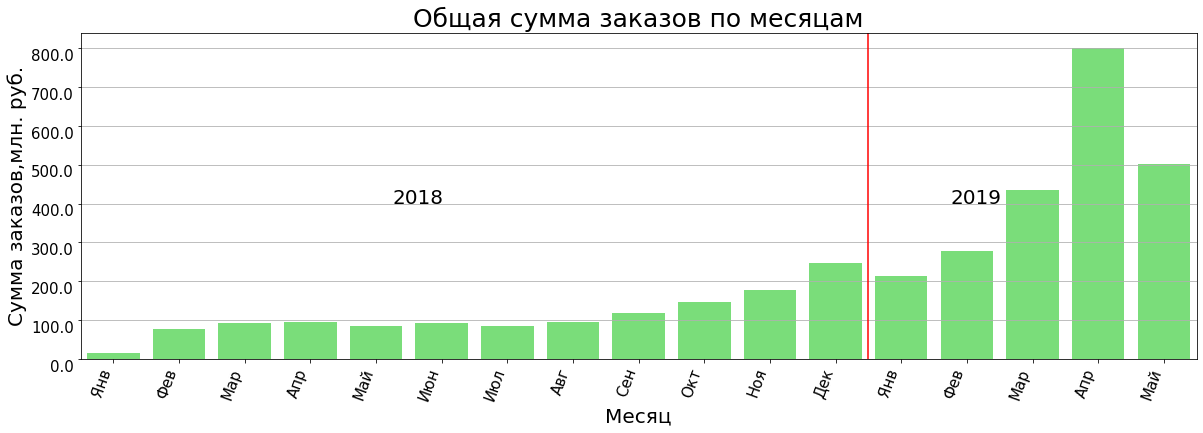

In [17]:
qplot = df_plot(df,'month','item_total','sum','Месяц','Сумма заказов,млн. руб.','Общая сумма заказов по месяцам')
qplot.set_yticklabels(qplot.get_yticks()/1000000,{'fontsize': 15,
    'fontweight': 50,
    'verticalalignment': 'top',
    'horizontalalignment': 'right'})
qplot

**Дела идут в гору.** Видно, что ресурс пользуется популярностью и в 2019 году количество заказов выросло в разы, в сравнении с предыдущим годом. Провал в августе свзяан с неполными данными за месяц.

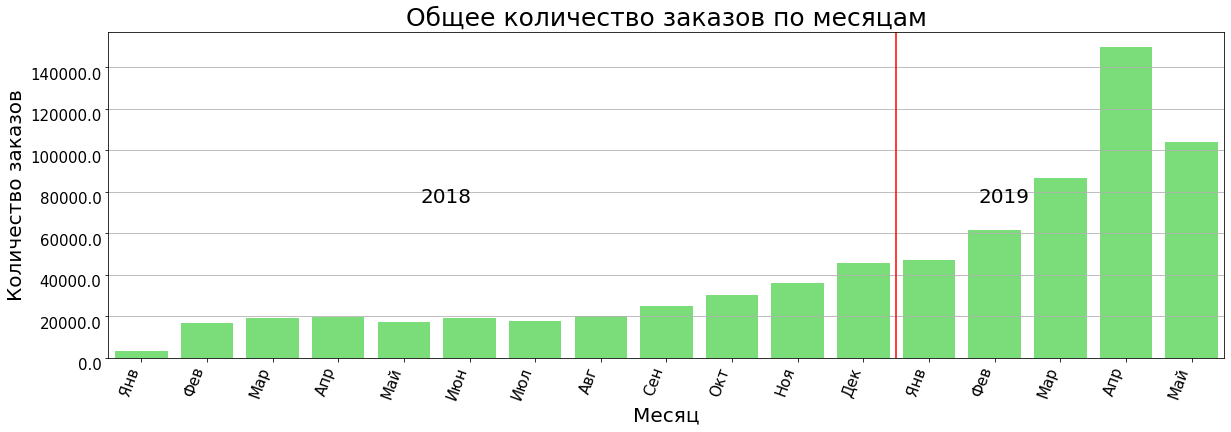

In [18]:
aplot = df_plot(df,'month','item_total','count','Месяц','Количество заказов','Общее количество заказов по месяцам')

**Этот график зависим от предыдущего**, но на нём можно посомтреть количество заказов.

(0.0, -4682735.231999994)

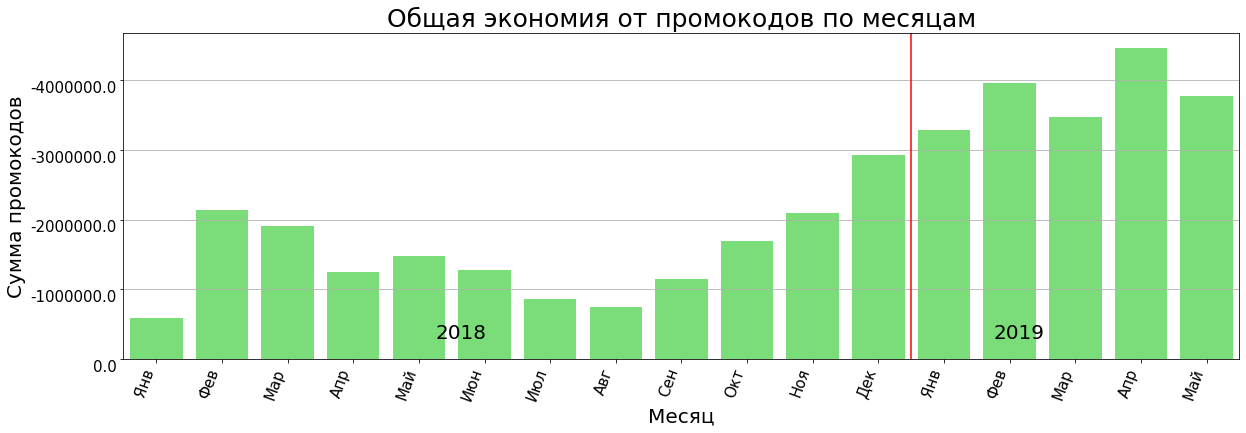

In [19]:
splot = df_plot(df[df['promo_total']<0],'month','promo_total','sum','Месяц','Сумма промокодов','Общая экономия от промокодов по месяцам')
splot = plt.gca()
splot.set_ylim(splot.get_ylim()[::-1])


**Клиенты в 2019 году активнее пользуются промокодами.** Однако к зиме второй год подряд интерес к промокодам падает, может стоит давать их чаще на горячий кофе ;)

(0.0, -760.6348364928907)

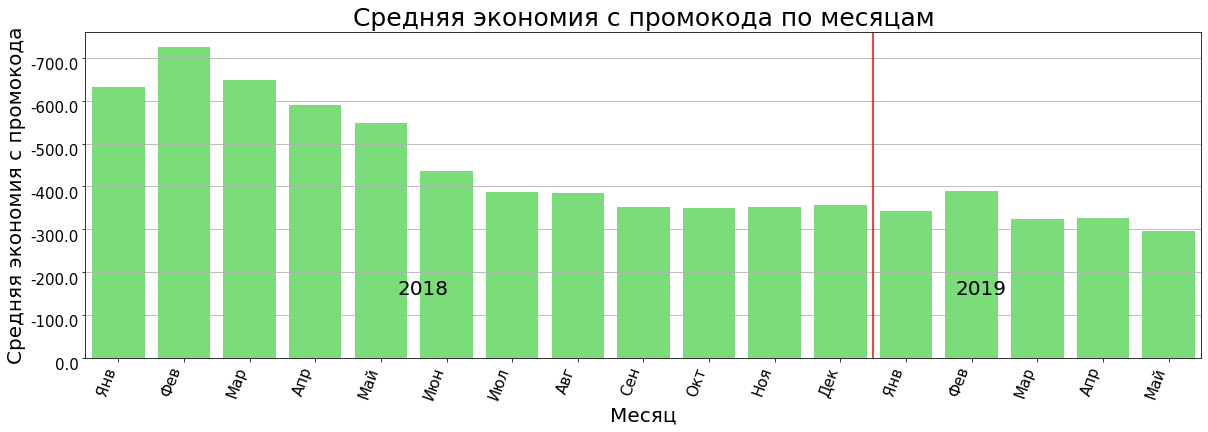

In [20]:
promplot = df_plot(df[df['promo_total']<0],'month',"promo_total",'mean','Месяц','Средняя экономия с промокода','Средняя экономия с промокода по месяцам')
prplot = plt.gca()
prplot.set_ylim(prplot.get_ylim()[::-1])

**Средняя величина промокода падает.** Пока прибывает количество клиентов и заказов - падение среднего промокода не вызывает опасений. Однако стоит следить за тем, что предлагают конкуренты, чтобы быть впереди.

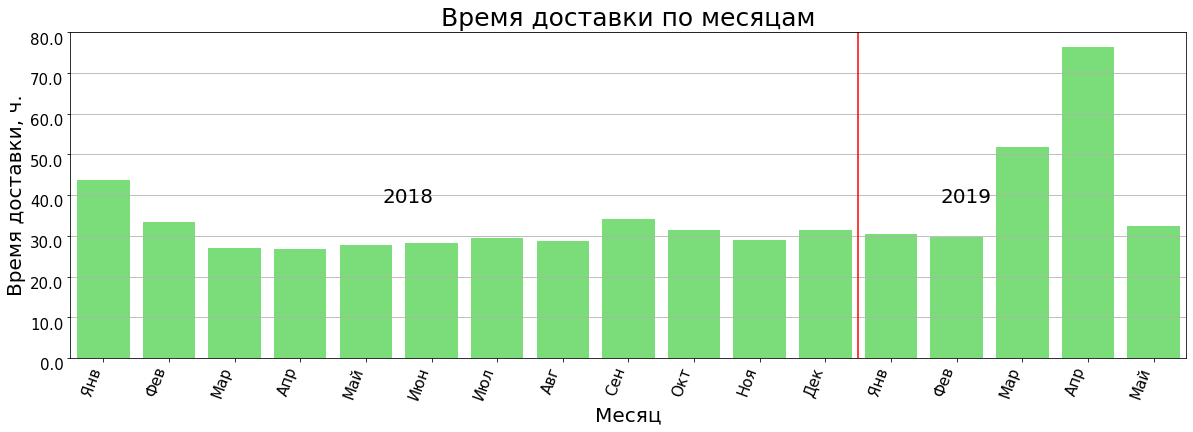

In [21]:
pplot = df_plot(df_clean,'month','packing_time','mean','Месяц','Время доставки, ч.','Время доставки по месяцам')

**Зимой продукты доставляют быстрее!** Возможно причина в том, что зимой работать остаются только опытные сотрудники, в то время, как летом работа курьера может рассматриваться, как сезонная. Разница в скорости доставки в зависимости от месяца может быть до 20%!

In [22]:
# Функция отрисочвки почасовых графиков
def df_plot_hour(df,group,what,agg,xlabel,ylabel,title):
    data = df.groupby(group)[what].agg(agg)
    f, ax = plt.subplots(figsize=(20, 6))
    ax = sns.barplot(data.keys(),data,color = '#69ee69')
    ax.set_xticklabels(ax.get_xticks(),{'fontsize': 15,
     'fontweight': 50,
     'verticalalignment': 'top',
     'horizontalalignment': 'right'})
    ax.set_yticklabels(ax.get_yticks(),{'fontsize': 15,
     'fontweight': 50,
     'verticalalignment': 'top',
     'horizontalalignment': 'right'})
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis = 'y')
    ax.set_xlabel(xlabel,size = 20)
    ax.set_ylabel(ylabel,size = 20)
    ax.set_title(title, size = 25)
    return ax

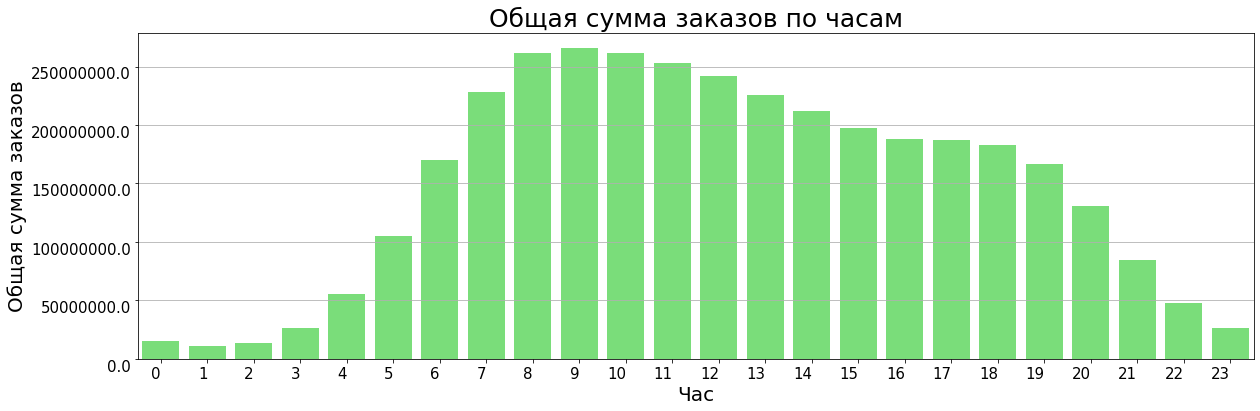

In [23]:
hplot = df_plot_hour(df,"hour","item_total",'sum','Час','Общая сумма заказов','Общая сумма заказов по часам')
hplot.set_yticklabels(hplot.get_yticks(),{'fontsize': 15,
    'fontweight': 50,
    'verticalalignment': 'top',
    'horizontalalignment': 'right'})
hplot

**Пик загрузки приходится на 8-9 утра**, нужно уделить внимание распорядку рабочего дня, потенциальная прибыль до обеда в два раза выше, чем после. Возможно, стоит сделать упор на доставку завтраков и продуктов для них.

(0.0, -2748446.473500002)

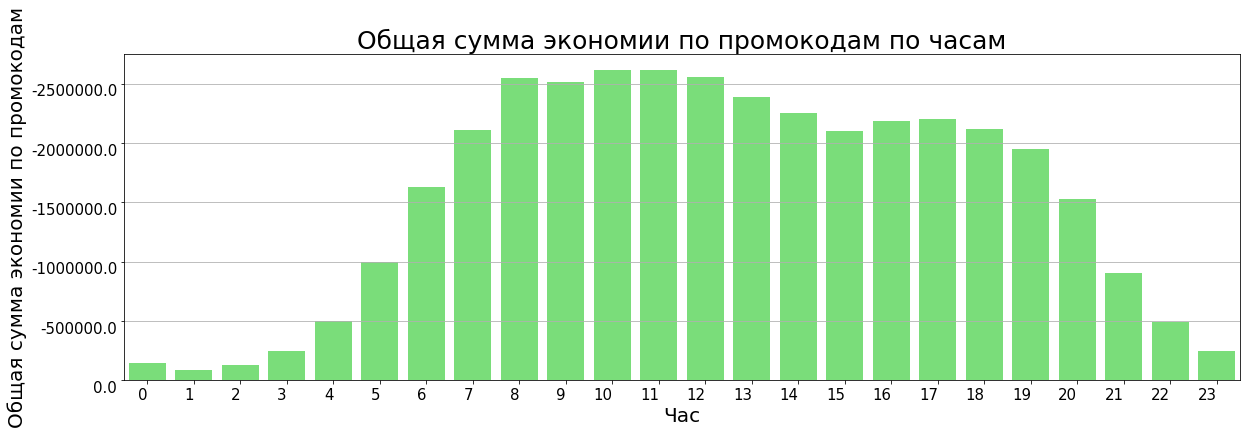

In [24]:
prplot = df_plot_hour(df[df['promo_total']<0],"hour","promo_total",'sum','Час','Общая сумма экономии по промокодам','Общая сумма экономии по промокодам по часам')
prplot = plt.gca()
prplot.set_ylim(prplot.get_ylim()[::-1])

**Клиенты пользуются промокодами равномерно.** Но всегда есть, куда двигаться. Как уже было выяснено ранее, пик заказов приходит на утро. Возможно, стоит сделать промокоды, которые привлекут клиентов утром?

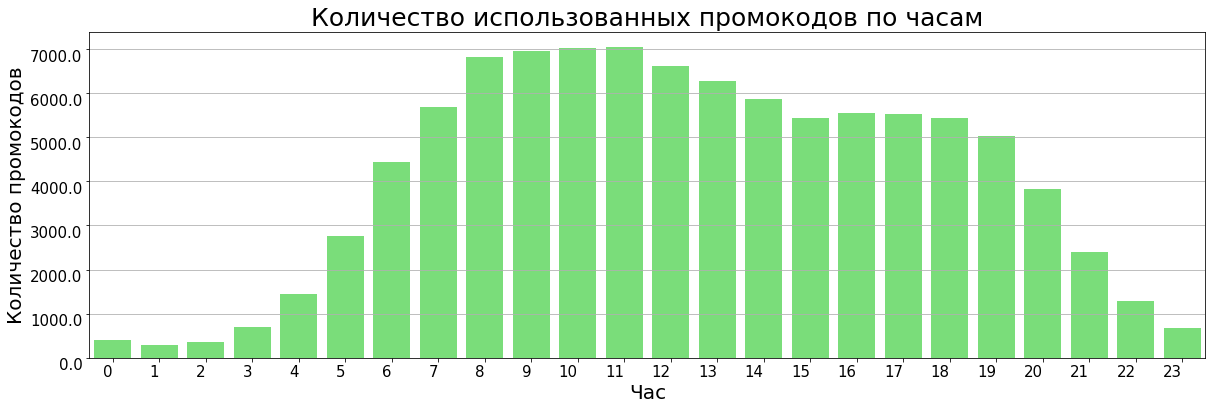

In [25]:
prplot = df_plot_hour(df[df['promo_total']<0],"hour","promo_total",'count','Час','Количество промокодов','Количество использованных промокодов по часам')

**После обеда клиенты используют более "тяжелые" промокоды.** При меньшем количестве промокодов после обеда, общая экономия с них сопоставима с тем, что наблюдается в утренние часы.  

(0.0, -418.4266152386116)

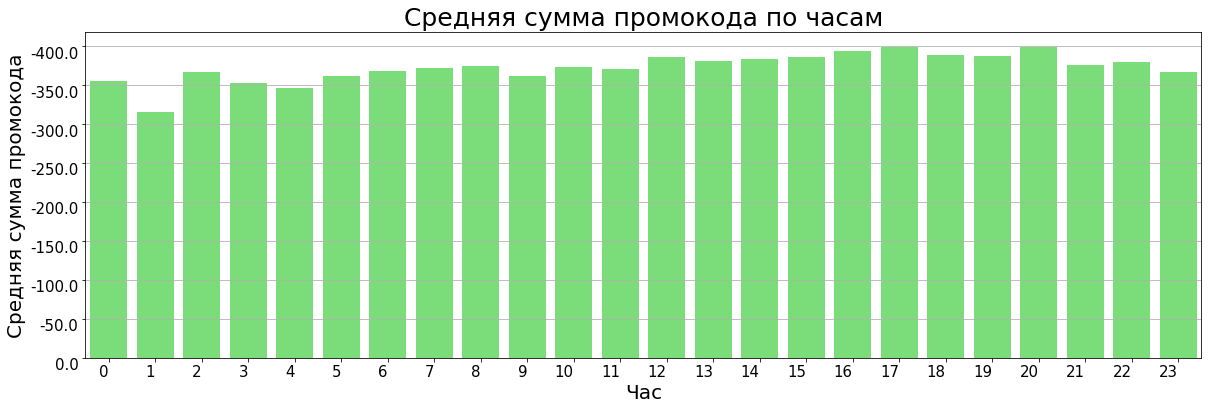

In [26]:
prplot = df_plot_hour(df[df['promo_total']<0],"hour","promo_total",'mean','Час','Средняя сумма промокода','Средняя сумма промокода по часам')
prplot = plt.gca()
prplot.set_ylim(prplot.get_ylim()[::-1])

**В дополнение к предыдущему графику.** Разница между суммой экономии по промокоду может быть около 10%. 